<h1 align="center"> Tweet sentiment analysis </h1>
<p>
</p>
<h2> Data set explanations: </h2>
<p>
</p>
<li> This dataset is meant for sentiment analysis of Twitter data. The objective is to determine the 
sentiment of a message towards an entity. The dataset comprises three classes: Positive, Negative, and Neutral. 
Messages that are not related to the entity are considered as Neutral. We have two data sets, one for training (twitter_training.csv)
and the other for validation (twitter_validation.csv). </li>


<h2> Methods used in this project : </h2>
<h3> Non-pretrained models: </h3>    
<ul>    
<li> RNN (With Gradient Clipping and Proper Weight Initialization)  </li>
<li> BiLSTM </li>
</ul>           
<h3> Pretrained models: </h3>  
<ul>          
<li> BERT </li>
<li> Mobile BERT </li>
<li> ALBERT </li>
</ul>
          
<p>
</p>          
<li> <strong> Important Note: </strong> Please note that due to my limited computational resources (laptop), I was unable to run pre-trained models on the dataset. Even fine tunning the pre-trained models for a few epochs takes a significant amount of time in my system. Therefore, I only created the models and ran the first epoch to ensure there were no errors or bugs. If you have access to more powerful computational resources (GPU or TPU), you are welcome to run the pre-trained models and compare the results with those of RNN and BiLSTM! </li>          
          

In [ ]:
# pip install wordcloud
# !pip install transformers --upgrade
# !pip install sentencepiece

In [1]:
import numpy as np
import pandas as pd
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from wordcloud import WordCloud
from tensorflow import keras

import re
import nltk
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
from transformers import BertTokenizer
from transformers import TFBertModel
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization, SpatialDropout1D
from keras.layers import Embedding, LSTM, Bidirectional, Input, SimpleRNN, Flatten
from keras.initializers import GlorotUniform

In [28]:
df_train = pd.read_csv('C:\\Users\\Afshin\\Pythonfiles\\Tweet sentiment analysis\\training.csv')
df_val = pd.read_csv('C:\\Users\\Afshin\\Pythonfiles\\Tweet sentiment analysis\\validation.csv')

<li> It seems that dataframe does not have heading, so we turn the heading into a proper name </li>

In [29]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [30]:
df_train.columns=['tweet_id','entity','sentiment','tweet_content']
df_val.columns=['tweet_id','entity','sentiment','tweet_content']

In [31]:
# concatinating train and validation sets
df = pd.concat([df_train,df_val], axis = 0).reset_index()

In [32]:
df.isnull().sum()

index              0
tweet_id           0
entity             0
sentiment          0
tweet_content    686
dtype: int64

In [33]:
# there are 686 Nan values in dataframe so we will drop them!
df.dropna(inplace = True)

In [34]:
df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

<li> Four sentiment categories </li>

In [35]:
sentiment_nums = Counter(df['sentiment'])
sentiment_nums

Counter({'Positive': 20931,
         'Neutral': 18393,
         'Negative': 22624,
         'Irrelevant': 13046})

<li> So there is a good blanace for each sentiment category. We also will remove the irrelevant sentiment Since it does not
help the model! </li>

<BarContainer object of 4 artists>

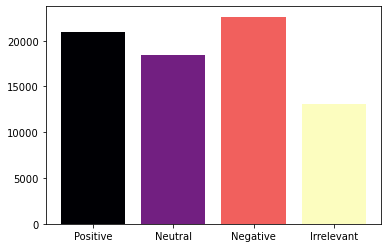

In [36]:
colors = plt.cm.magma(np.linspace(0, 1, len(sentiment_nums)))
# colors = ['firebrick', 'navy', 'green', 'orange']
plt.bar(sentiment_nums.keys(), sentiment_nums.values(), color = colors)

In [37]:
# removing Irrelevant category 
df = df[df['sentiment'].apply(lambda x: 'Irrelevant' not in x)]
df

,index,tweet_id,entity,sentiment,tweet_content
0,0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...,...
75673,992,314,Amazon,Negative,Please explain how this is possible! How can t...
75674,993,9701,PlayStation5(PS5),Positive,Good on Sony. As much as I want to see the new...
75677,996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75678,997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


<h3> Feature plotting </h3>

<li> I plot the content in the word cloud to see the frequncy of the words repeated in the content.We can see some curse 
word in negative wordcloud, some positive and kind word in the positive wordcloud. </li>

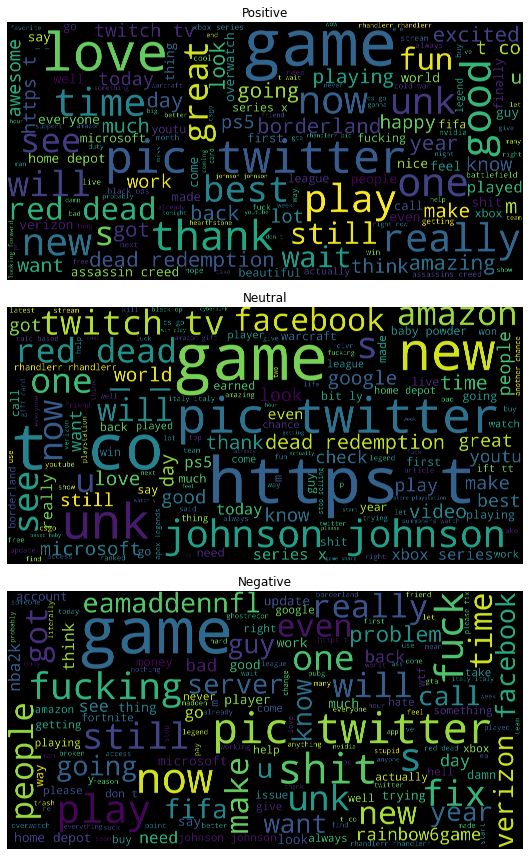

In [38]:
sentiments = ['Positive', 'Neutral', 'Negative']

fig, axs = plt.subplots(nrows=len(sentiments), ncols=1, figsize=(16, 12))

for i, ax in enumerate(axs):
    df_pos = df[df['sentiment'] == sentiments[i]]
    contents = ' '.join(df_pos['tweet_content'].str.lower())
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=150,
        background_color="black",
        scale=15,
        width=800,
        height=400
    ).generate(contents)
    #Figure properties
#     ax.figure(figsize=(16,12))
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f'{sentiments[i]}')
    
plt.tight_layout()
plt.show()    
    

<li> Based on the histogram below we can say that most negative comments belongs to "MaddenNFL", most positive belongs to 
'AssassinCreed' and most neutral is for 'Amazon'. </li>

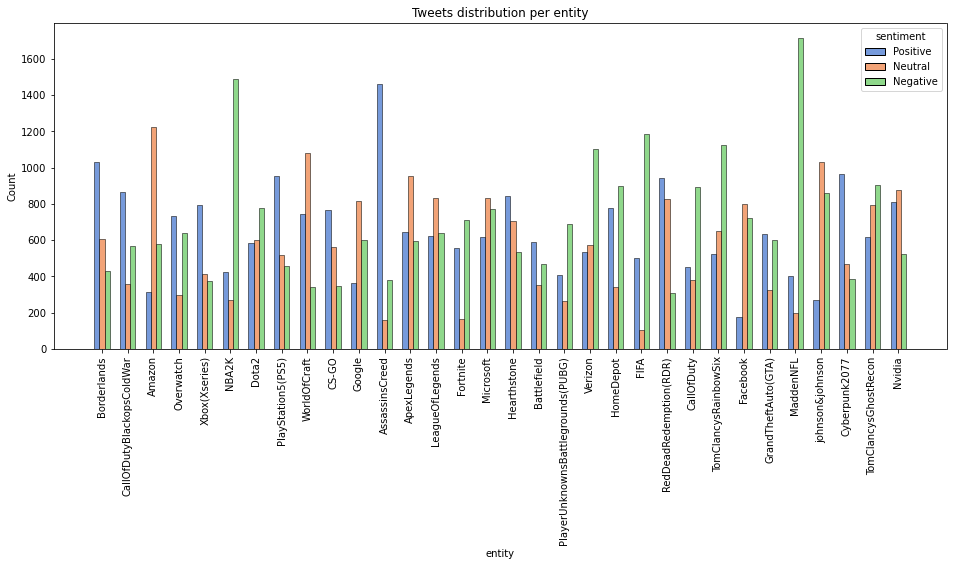

In [39]:
plt.figure(figsize=(16,6))
sns.histplot(data=df, x="entity", hue = 'sentiment', multiple="dodge", shrink=.6, palette='muted')
plt.xticks(rotation=90)
plt.title("Tweets distribution per entity");
plt.show()

In [40]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)



REPLICAS:  1


In [41]:
# checking the GPU

if tf.config.list_physical_devices('GPU'):
    print('GPU is available and being used.')
else:
    print('GPU is not available.')

GPU is not available.


<h3> Data cleaning </h3>

<li> The function below cleans the tweet contect by removing non alphabetic characters, lemmatizing the words
and excluding stop words in the content! </li>

In [42]:
lemmatizer = WordNetLemmatizer()
stopwords_ = stopwords.words('english')
stops = set(stopwords_)

def clean_content(x):
    
    # removing non alphabetic characters
    text = re.sub("[^A-Za-z]", " ",x)
    # removing links
    text = re.sub(r'http\S+', '', text)
    # removing mentions
    text = re.sub(r'@\S+', '', text)
    # lower case and split the content
    split_lower_word = text.lower().split()
    # lemmatizing words if they not stopwords
    cleaned_text = [lemmatizer.lemmatize(word) for word in split_lower_word if word not in stops]
    # joining the list to create a string
    cleaned_text= " ".join(cleaned_text)
    
    return cleaned_text


In [43]:
# adding the cleaned content as a new column to the dataframe
df['cleaned_content'] = df['tweet_content'].map(lambda x: clean_content(x))
df

,index,tweet_id,entity,sentiment,tweet_content,cleaned_content
0,0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
1,1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill
2,2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderland murder
3,3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder
4,4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderland murder
...,...,...,...,...,...,...
75673,992,314,Amazon,Negative,Please explain how this is possible! How can t...,please explain possible let company overcharge...
75674,993,9701,PlayStation5(PS5),Positive,Good on Sony. As much as I want to see the new...,good sony much want see new p going right much...
75677,996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,today sucked time drink wine n play borderland...
75678,997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,bought fraction microsoft today small win


In [44]:
df['content_length'] = df['cleaned_content'].map(lambda x : len(x.split()))                                           

<li> Based on the graph shown below, it can be observed that 99.87% of the tweet contents have a character length of 
less than 40. Therefore, a max_len of 40 can be chosen for tokenization and padding without significant loss of 
information. An alternative would be to choose the maximum length of tokens, which is 163, but this may lead to 
significantly higher computational time. In light of this, I will choose a max_length of 40 for now. </li> 

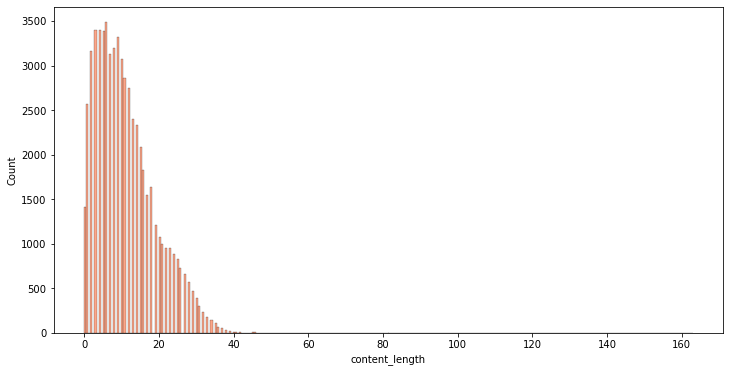

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = df['content_length'], color='#FB8861')
plt.show()

In [46]:
max_content_lenght= df['content_length'].max()
print(f' the maximum length of tokens is : {max_content_lenght}')

 the maximum length of tokens is : 163


In [47]:
round(df['content_length'].apply(lambda x : x < 40).sum() * 100 /len(df),2)

99.88

<li> Since the information in columns of 'tweet_id', 'entity', 'tweet_content' and 'content_length' are useless, we will 
drop the columns </li>

In [48]:
df.drop(['tweet_id', 'entity', 'tweet_content', 'content_length'], inplace = True, axis = 1)

In [49]:
# one hot encoding of sentiments and droping the unnecessary columns
df2_dummy = pd.get_dummies(df['sentiment'])
df = pd.concat([df, df2_dummy], axis = 1)
df.drop(['index', 'sentiment'], axis = 1, inplace = True)
df

,cleaned_content,Negative,Neutral,Positive
0,coming border kill,0,0,1
1,im getting borderland kill,0,0,1
2,im coming borderland murder,0,0,1
3,im getting borderland murder,0,0,1
4,im getting borderland murder,0,0,1
...,...,...,...,...
75673,please explain possible let company overcharge...,1,0,0
75674,good sony much want see new p going right much...,0,0,1
75677,today sucked time drink wine n play borderland...,0,0,1
75678,bought fraction microsoft today small win,0,0,1


<h3> Tokenization & Vectorization </h3>

<li> Tokenizing the content, converting it to sequence then zero padding the sequence with max length of 40 
which we already estimate it above </li>

In [50]:
tokenizer  = Tokenizer()
max_length = 40

def tokenizer_zeropadding(df_input, max_length):

    tokenizer.fit_on_texts(df_input)
    sequence = tokenizer.texts_to_sequences(df_input)
#   zero padding
    res = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    return res


In [51]:
target_cols = ['Negative', 'Neutral', 'Positive']
X = tokenizer_zeropadding(df['cleaned_content'], max_length)
y = np.array(df[target_cols])

# vocab size + 1 is fed into embedding layer as input dim
# https://keras.io/api/layers/core_layers/embedding/

vocab_size = len(tokenizer.word_index)
word_index = tokenizer.word_index

In [52]:
# train, test and validation split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val   = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

<h2> Classification </h2>

<h3> 1. RNN (with Gradient Clipping and Proper Weight Initialization) </h3>

<li> As we know, RNNs suffer from the vanishing/exploding gradient problem, which can affect their performance during 
training. To address this issue, I use techniques such as <strong>gradient clipping</strong>, <strong>proper weight 
initialization</strong>, and <strong>BatchNormalization </strong> when building RNN models. As we all know, applying 
these techniques to a simple RNN can significantly improve its performance compared to an RNN without them.</li>

In [244]:
def base_model_rnn(vocab_size, input_shape):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        output_dim  = 32, 
                        input_length = input_shape
                       ))
    model.add(SimpleRNN(32, kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.02))
    model.add(BatchNormalization())
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(3,  activation = 'softmax'))
    
    return model

optimizer = Adam(learning_rate=0.0005, amsgrad=True, clipnorm=0.1)
rnn_model = base_model_rnn(vocab_size, input_shape = X_train.shape[1])
rnn_model.summary()   

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 40, 32)            752096    
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dropout_470 (Dropout)       (None, 32)                0         
                                                                 
 batch_normalization_23 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_49 (Dense)            (None, 24)                792       
                                                                 
 dense_50 (Dense)            (None, 3)                 75        
                                                     

In [245]:
rnn_model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = rnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
1569/1569 [==============================] - 32s 20ms/step - loss: 0.8686 - accuracy: 0.5928 - val_loss: 0.6891 - val_accuracy: 0.7183
Epoch 2/100
1569/1569 [==============================] - 30s 19ms/step - loss: 0.4541 - accuracy: 0.8259 - val_loss: 0.5152 - val_accuracy: 0.8031
Epoch 3/100
1569/1569 [==============================] - 34s 21ms/step - loss: 0.2876 - accuracy: 0.8921 - val_loss: 0.4897 - val_accuracy: 0.8198
Epoch 4/100
1569/1569 [==============================] - 29s 18ms/step - loss: 0.2188 - accuracy: 0.9161 - val_loss: 0.4935 - val_accuracy: 0.8407
Epoch 5/100
1569/1569 [==============================] - 29s 18ms/step - loss: 0.1801 - accuracy: 0.9306 - val_loss: 0.5474 - val_accuracy: 0.8443
Epoch 6/100
1569/1569 [==============================] - 29s 18ms/step - loss: 0.1556 - accuracy: 0.9388 - val_loss: 0.5661 - val_accuracy: 0.8477
Epoch 7/100
1569/1569 [==============================] - 29s 19ms/step - loss: 0.1409 - accuracy: 0.9448 - val_loss: 0

194/194 [==============================] - 1s 4ms/step

---------------------------------------------------
RNN accuracy for test set : 0.84
RNN micro-averaged precision for test set : 0.87
RNN micro-averaged recall for test set : 0.82
---------------------------------------------------


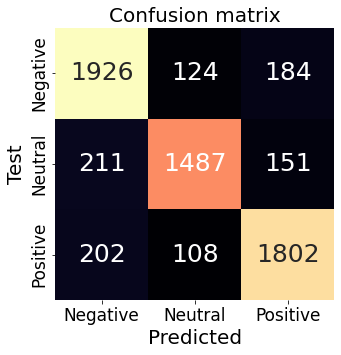

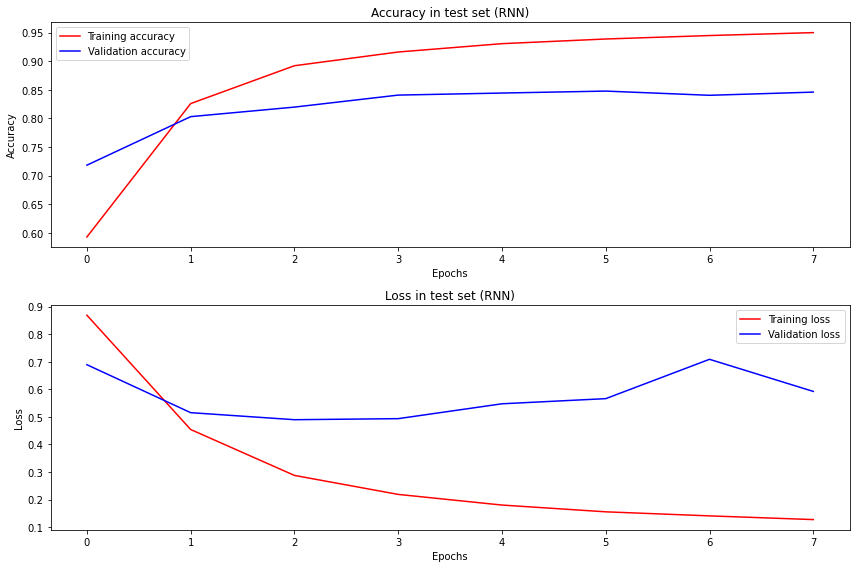

In [246]:
accu_metric = rnn_model.evaluate(X_test,y_test)
y_pred      = rnn_model.predict(X_test)
y_pred = y_pred > 0.5
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')

print('')
print('---------------------------------------------------')
print(f'RNN accuracy for test set : {round(accu_metric[1],2)}')
print(f'RNN micro-averaged precision for test set : {round(precision,2)}')
print(f'RNN micro-averaged recall for test set : {round(recall,2)}')
print('---------------------------------------------------')

conf_matrix(np.array(y_test).argmax(axis=1), y_pred.argmax(axis=1), 'Confusion matrix')

plot_results(history, 'RNN')


<h3> 2. BiLSTM </h3>

<li> <strong>BiLSTM</strong> uses two LSTM layers: one that reads the input sequence from left to right and the other that reads it from right to left. By processing the sequence in both directions, the model can capture dependencies and patterns that may be missed by a unidirectional LSTM. </li>

In [122]:
def plot_results(history, model_name):
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(12, 8))
    
    ax[0].plot(history.history['accuracy'], color='red')
    ax[0].plot(history.history['val_accuracy'], color='blue')
    ax[0].legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
    ax[0].set_title(f'Accuracy in test set ({model_name})')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].plot(history.history['loss'], color='red')
    ax[1].plot(history.history['val_loss'], color='blue')
    ax[1].legend(['Training loss', 'Validation loss'], loc='upper right')
    ax[1].set_title(f'Loss in test set ({model_name})')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')           
               
    fig.tight_layout()
    plt.show()

In [123]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="magma", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [124]:
def BiLSTM_base_model(vocab_size, input_shape):

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size + 1 , output_dim  = 32, input_length = input_shape))
    model.add(Bidirectional(LSTM(32, dropout=0.4, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
#     model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(3,  activation = 'softmax'))  
    
    return model

BiLSTM_model = BiLSTM_base_model(vocab_size, input_shape = X_train.shape[1])
BiLSTM_model.summary()              

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            752192    
                                                                 
 bidirectional (Bidirectiona  (None, 40, 64)           16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_449 (Dropout)       (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 24)                1560      
                                                                 
 dense_6 (Dense)             (None, 3)                 7

In [214]:
epoch = 100
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)
callback = EarlyStopping(monitor='val_loss', patience=5)

In [54]:
BiLSTM_model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = BiLSTM_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])


Epoch 1/100
2091/2091 [==============================] - 84s 37ms/step - loss: 0.7936 - accuracy: 0.6220 - val_loss: 0.4822 - val_accuracy: 0.8156
Epoch 2/100
2091/2091 [==============================] - 77s 37ms/step - loss: 0.4001 - accuracy: 0.8504 - val_loss: 0.3418 - val_accuracy: 0.8680
Epoch 3/100
2091/2091 [==============================] - 77s 37ms/step - loss: 0.2908 - accuracy: 0.8899 - val_loss: 0.3397 - val_accuracy: 0.8754
Epoch 4/100
2091/2091 [==============================] - 78s 37ms/step - loss: 0.2415 - accuracy: 0.9069 - val_loss: 0.2949 - val_accuracy: 0.8919
Epoch 5/100
2091/2091 [==============================] - 78s 37ms/step - loss: 0.2077 - accuracy: 0.9188 - val_loss: 0.2894 - val_accuracy: 0.8969
Epoch 6/100
2091/2091 [==============================] - 78s 37ms/step - loss: 0.1913 - accuracy: 0.9248 - val_loss: 0.2831 - val_accuracy: 0.8992
Epoch 7/100
2091/2091 [==============================] - 78s 37ms/step - loss: 0.1769 - accuracy: 0.9299 - val_loss: 0

194/194 [==============================] - 3s 10ms/step

---------------------------------------------------
BiLSTM accuracy for test set : 0.91
BiLSTM micro-averaged precision for test set : 0.93
BiLSTM micro-averaged recall for test set : 0.9
---------------------------------------------------


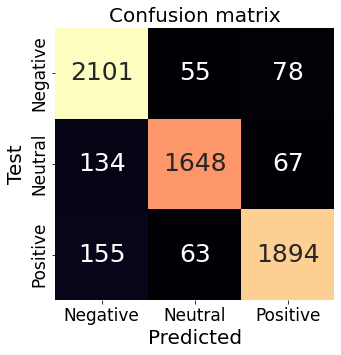

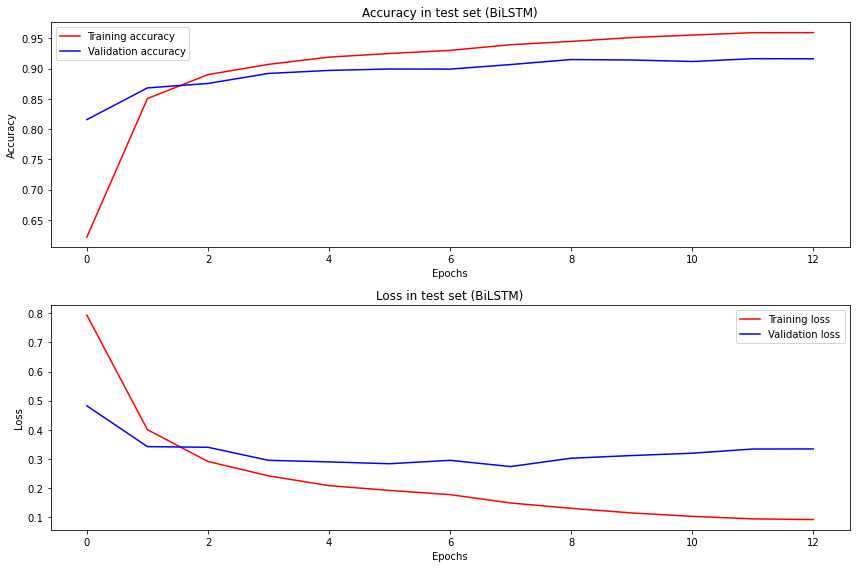

In [55]:
accu_metric = BiLSTM_model.evaluate(X_test,y_test)
y_pred      = BiLSTM_model.predict(X_test)
y_pred = y_pred > 0.5
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')

print('')
print('---------------------------------------------------')
print(f'BiLSTM accuracy for test set : {round(accu_metric[1],2)}')
print(f'BiLSTM micro-averaged precision for test set : {round(precision,2)}')
print(f'BiLSTM micro-averaged recall for test set : {round(recall,2)}')
print('---------------------------------------------------')

conf_matrix(np.array(y_test).argmax(axis=1), y_pred.argmax(axis=1), 'Confusion matrix')

plot_results(history, 'BiLSTM')


<h3> 3. BERT </h3>

<li> <strong>BERT</strong> (Bidirectional Encoder Representations from Transformers) is a pre-trained language model 
developed by Google. It uses the transformer architecture, with self-attention mechanisms. BERT was pre-trained on large 
amounts of unlabeled text data and then fine-tuned on downstream tasks such as text classification, question answering,
and named entity recognition.</li>
<p>
</p>
<li> BERT is unique in that it is a bidirectional model, meaning it takes into account both the left and right contexts 
of each word in a sentence, unlike previous models which were only unidirectional. This allows BERT to have a deeper 
understanding of language and perform better on tasks that require context and understanding. </li>
<p>
</p>
<li> BERT is available in different sizes, from the small "BERT-Base" with <strong>110 million parameters </strong> to the large "BERT-Large" 
with <strong>340 million parameters</strong>. It has been used in a wide range of natural language processing applications and has 
achieved state-of-the-art results on many benchmark datasets.</li>

In [58]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_tokenizer(data, max_length):

    # Tokenize the text column
    data['input_token'] = data['cleaned_content'].apply(lambda x: [tokenizer_bert.encode(x, add_special_tokens=True)])
    data['mask_token'] = data['input_token'].apply(lambda x: [[1] * len(x)])

    # Pad the input sequences to a fixed length
    data['input_padded'] = data['input_token'].apply(lambda x: pad_sequences(x, maxlen=max_length, padding='post'))
    data['mask_padded']  = data['mask_token'].apply(lambda x: pad_sequences(x, maxlen=max_length, padding='post'))
    
    input_ids= []
    attention_mask= []
    
    # appending sequences for input_ids and attention masks
    for indx, row in data.iterrows():
        
        input_ids.append(row['input_padded'][0])
        attention_mask.append(row['mask_padded'][0])
        
    return np.array(input_ids), np.array(attention_mask)    
    

<li> Alternative mehtod for getting input_ids and attention mask is to use encode_plus of HuggingFace </li>

In [59]:
# input_ids = []
# attention_masks = []
# for i in range(len(df)):
#     encoded = tokenizer.encode_plus(
#         data[i],
#         add_special_tokens=True,
#         max_length=MAX_LEN,
#         padding='max_length',
#         return_attention_mask=True
#     )
#     input_ids.append(encoded['input_ids'])
#     attention_masks.append(encoded['attention_mask'])

In [60]:
target_cols = ['Negative', 'Neutral', 'Positive']
train_indx = int(0.8*len(df))
val_indx   = int(0.9*len(df))

df_shuffled = df.sample(frac=1).reset_index(drop=True)

df_train      = df_shuffled.loc[: train_indx].reset_index(drop=True)
y_train_bert  = np.array(df_train[target_cols])
df_val        = df_shuffled.loc[train_indx : val_indx].reset_index(drop=True)
y_val_bert    = np.array(df_val[target_cols])
df_test       = df_shuffled.loc[val_indx :].reset_index(drop=True)
y_test_bert   = np.array(df_test[target_cols])

In [61]:
train_input_ids, train_attention_masks = bert_tokenizer(df_train, max_length = max_length)
val_input_ids, val_attention_masks     = bert_tokenizer(df_val, max_length = max_length)
test_input_ids, test_attention_masks   = bert_tokenizer(df_test, max_length = max_length)

In [54]:
train_input_ids.shape

(49559, 45)

In [62]:
# Load the pre-trained BERT model and tokenizer

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define the model input
# Run the input through the BERT model

input_ids = Input(shape=(max_length,),dtype='int32')
attention_masks = Input(shape=(max_length,),dtype='int32')
embeddings = bert_model([input_ids,attention_masks])[1]
output = Dense(3, activation="softmax")(embeddings)
BERT_model = keras.Model(inputs = [input_ids,attention_masks], outputs = output)



BERT_model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])
BERT_model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model_5 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                          

In [64]:
history = BERT_model.fit([train_input_ids,train_attention_masks], y_train_bert,
                         validation_data=([val_input_ids,val_attention_masks], y_val_bert), epochs = epoch, 
                         batch_size = batch_size, callbacks=[callback])

In [ ]:
# Evaluate the model
model.evaluate(test_inputs, test_labels)

<h3> 4. Mobile BERT </h3>

<li> <strong> MobileBERT </strong> is a mobile-friendly version of the BERT model, developed by Google Research. It is designed to be smaller
and faster than BERT, making it more suitable for on-device NLP applications on mobile and 
embedded devices. MobileBERT achieves this by using a lightweight transformer architecture and a combination of 
techniques such as knowledge distillation and network pruning ended up having <strong> 54 million parameter </strong>. Despite its smaller size, MobileBERT has been shown 
to achieve similar or even better performance than BERT on a range of NLP tasks.</li>

In [68]:
import tensorflow as tf
from transformers import MobileBertTokenizerFast, TFBertForSequenceClassification


# Define the MobileBERT tokenizer
tokenizer_mobilebert = MobileBertTokenizerFast.from_pretrained('google/mobilebert-uncased')

# Tokenize the cleaned_content
train_encodings = tokenizer_mobilebert(list(df_train['cleaned_content']), truncation=True, 
                                       padding=True, max_length=max_length)
val_encodings   = tokenizer_mobilebert(list(df_val['cleaned_content']), truncation=True,
                                       padding=True, max_length=max_length)
test_encodings  = tokenizer_mobilebert(list(df_test['cleaned_content']), truncation=True,
                                       padding=True, max_length=max_length)

# Convert labels to numpy arrays
train_labels  = np.array(df_train[target_cols])
val_labels    = np.array(df_val[target_cols])
test_labels   = np.array(df_test[target_cols])


# Convert the encoded input to a numpy array
input_ids_train = np.array(train_encodings['input_ids'])
attention_mask_train = np.array(train_encodings['attention_mask'])

input_ids_val = np.array(val_encodings['input_ids'])
attention_mask_val = np.array(val_encodings['attention_mask'])

# Define the MobileBERT model
model_mobile_bert = TFBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=3)

model_mobile_bert.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_mobile_bert.summary()


# Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(test_encodings, test_labels)
# print(f"Test accuracy: {test_acc}")

You are using a model of type mobilebert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at google/mobilebert-uncased were not used when initializing TFBertForSequenceClassification: ['predictions___cls', 'mobilebert', 'seq_relationship___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['cl

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  54025728  
                                                                 
 dropout_448 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1539      
                                                                 
Total params: 54,027,267
Trainable params: 54,027,267
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model_mobile_bert.fit([input_ids_train, attention_mask_train], train_labels,
                         validation_data=([input_ids_val, attention_mask_val], val_labels), epochs = epoch, 
                         batch_size = batch_size, callbacks=[callback])

<h3> 5. ALBERT </h3>

<li> <strong >ALBERT (A Lite BERT) </strong> is a variation of the BERT model. It is originally designed to address the computational limitations of 
the original BERT model by reducing the number of parameters while maintaining the model's accuracy. This was achieved 
through techniques such as parameter sharing and cross-layer parameter sharing.</li>
<p>
</p>
<li> As a result, ALBERT achieves state-of-the-art performance on a wide range of NLP tasks with fewer parameters and 
lower computational costs than the original BERT model. It has <strong >12 million parameters.</strong> </li>

In [37]:
target_cols = ['Negative', 'Neutral', 'Positive']
train_indx = int(0.8*len(df))
val_indx   = int(0.9*len(df))

df_shuffled = df.sample(frac=1).reset_index(drop=True)

df_train      = df_shuffled.loc[: train_indx].reset_index(drop=True)
y_train_bert  = np.array(df_train[target_cols])
df_val        = df_shuffled.loc[train_indx : val_indx].reset_index(drop=True)
y_val_bert    = np.array(df_val[target_cols])
df_test       = df_shuffled.loc[val_indx :].reset_index(drop=True)
y_test_bert   = np.array(df_test[target_cols])

In [38]:
# Load tokenizer 
tokenizer_albert = AlbertTokenizer.from_pretrained('albert-base-v2')


train_encodings = tokenizer_albert(list(df_train['cleaned_content']), truncation=True, 
                                   padding=True, max_length=max_length)
val_encodings   = tokenizer_albert(list(df_val['cleaned_content']), truncation=True, 
                                   padding=True, max_length=max_length)
test_encodings  = tokenizer_albert(list(df_test['cleaned_content']), truncation=True, 
                                   padding=True, max_length=max_length)

# Convert labels to numpy arrays
train_labels  = np.array(df_train[target_cols])
val_labels    = np.array(df_val[target_cols])
test_labels   = np.array(df_test[target_cols])


# Convert the encoded input to a numpy array
input_ids_train = np.array(train_encodings['input_ids'])
attention_mask_train = np.array(train_encodings['attention_mask'])

input_ids_val = np.array(val_encodings['input_ids'])
attention_mask_val = np.array(val_encodings['attention_mask'])


# Define the ALBERT model
albert_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)


epoch = 4
batch_size = 32
optimizer = Adam(learning_rate=0.005, amsgrad=True)
callback = EarlyStopping(monitor='val_loss', patience=5)


albert_model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])
albert_model.summary()



All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_albert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  11683584  
                                                                 
 dropout_189 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 11,685,891
Trainable params: 11,685,891
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = albert_model.fit([input_ids_train, attention_mask_train], train_labels,
                         validation_data=([input_ids_val, attention_mask_val], val_labels), epochs = epoch, 
                         batch_size = batch_size, callbacks=[callback])

<h3> Results </h3>

<li> <strong> Important Note: </strong> Please note that due to my limited computational resources (laptop), I was unable 
to run pre-trained models on the dataset. It takes a significant amount of time to complete even the first epoch. 
Therefore, I only created the models and ran the first epoch to ensure there were no errors or bugs. If you have access
to more powerful computational resources (GPU or TPU), you are welcome to run the pre-trained models and compare the results 
with those of RNN and BiLSTM! </li>

<p>
</p>
<li> So for now I only compare the results of RNN and BiLSTM which are evaluated for test set:</li>
  
<h4> RNN (With Gradient Clipping and Proper Weight Initialization): </h4>    
<ul>
<li> Accuracy                 : 0.84 </li>
<li> Micro-averaged precision : 0.87 </li>
<li> Micro-averaged recall    : 0.82 </li>
</ul>      
<h4> BiLSTM: </h4>  
<ul>    
<li> Accuracy                  : 0.91 </li>
<li> Micro-averaged precision  : 0.93 </li>
<li> Micro-averaged recall     : 0.9  </li>
</ul>    

